In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score
import numpy as np
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
# creating custom estimators using sklearn interfaces
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## Helper classes and functions

In [2]:
# helpers
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
# using a custom class to  apply transformation of the
# rooms / bedrooms previously done manually
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

# helper for splitting test data
def test_data(rows=True):
    if rows is True:
        X_test = strat_test_set[[x for x in strat_test_set if x != 'median_house_value']]
        Y_test = strat_test_set['median_house_value']
        return X_test,Y_test
    X_test = strat_test_set[:rows][[x for x in strat_test_set if x != 'median_house_value']]
    Y_test = strat_test_set[:rows]['median_house_value']
    return X_test,Y_test

In [3]:
df = pd.read_csv(r'../Datasets/housing.csv')

In [4]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

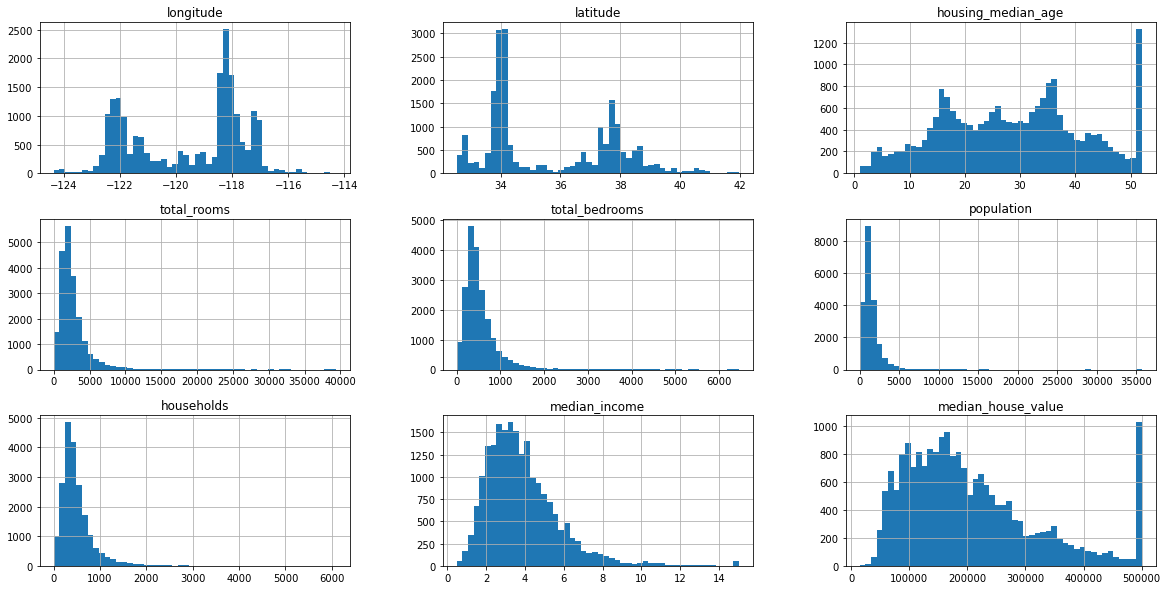

In [7]:
df.hist(bins=50,figsize=(20,10))
plt.show()

In [8]:
train_set, test_set = train_test_split(df,random_state=42,test_size=.2)

In [9]:
df['median_income'].describe()

count    20640.000000
mean         3.870671
std          1.899822
min          0.499900
25%          2.563400
50%          3.534800
75%          4.743250
max         15.000100
Name: median_income, dtype: float64

In [10]:
df['income_cat'] = pd.cut(df["median_income"],
bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
labels=[1, 2, 3, 4, 5])

<AxesSubplot:>

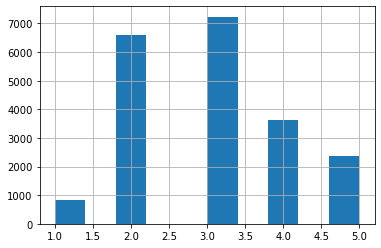

In [11]:
df['income_cat'].hist()

In [12]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [13]:
for v in (strat_test_set,strat_train_set):
    v.drop(columns=['income_cat'],inplace=True)

In [14]:
# setting an exploration set
housing = strat_train_set.copy()

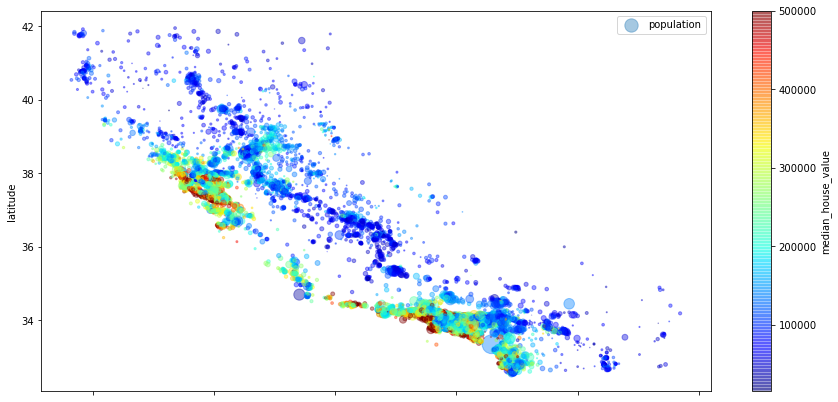

In [15]:
housing.plot(
    kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(15,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()
plt.show()

In [16]:
corr = housing.corr()

In [17]:
corr['median_income'].sort_values(ascending=False)

median_income         1.000000
median_house_value    0.687160
total_rooms           0.200087
households            0.010781
population            0.002380
total_bedrooms       -0.009740
longitude            -0.019583
latitude             -0.075205
housing_median_age   -0.111360
Name: median_income, dtype: float64

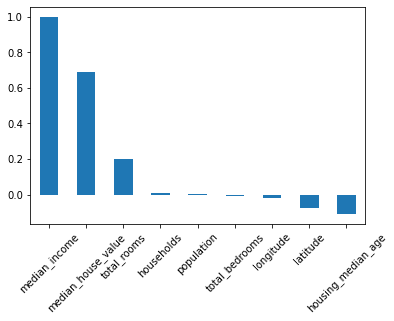

In [18]:
corr['median_income'].sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=45)
plt.show()

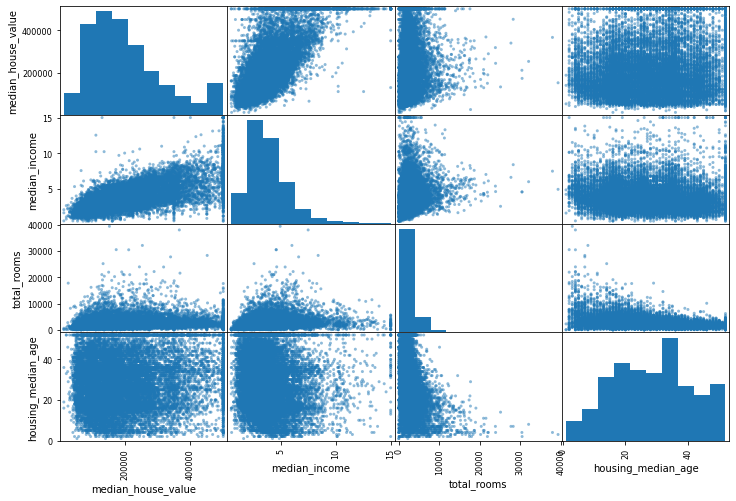

In [19]:
attributes = ["median_house_value", "median_income", "total_rooms",
    "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

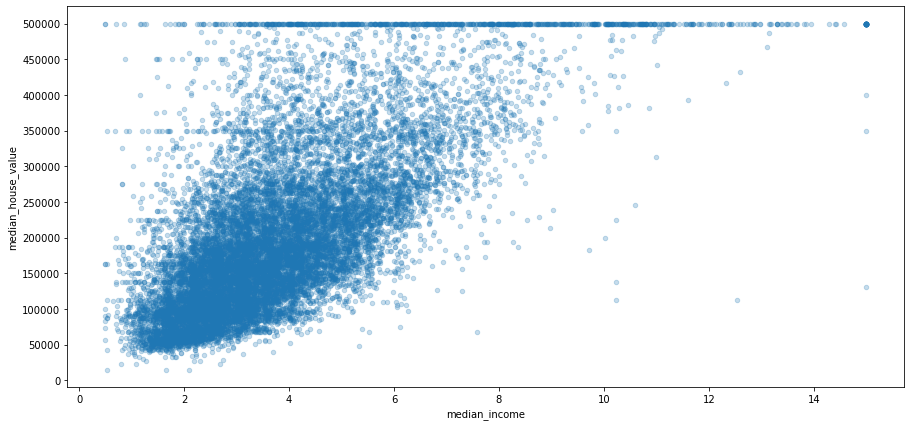

In [20]:
# zooming in the feature with the most correlation
housing.plot(kind='scatter',x='median_income',y='median_house_value',alpha=.25, figsize=(15,7))
plt.yticks(ticks=np.arange(0,550000,50000))
plt.show()

In [21]:
# it is a good practice to test hypothesis
# by creating combined fields that might make more sense than
# indivisual fields
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [22]:
corr_matrix = housing.corr()

In [23]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [24]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [25]:
imputer = SimpleImputer(strategy='median')

In [26]:
# excluding the text fields to use the imputer
housing_num = housing.drop(columns=housing.select_dtypes(include='object').columns).copy()

In [27]:
# using the imputer method fill missing values in numerical features
imputer.fit(housing_num)
X = imputer.transform(housing_num)
housing_num_transformed = pd.DataFrame(X,columns=housing_num.columns,index=housing_num.index)

In [28]:
housing_cat = housing.select_dtypes('object').copy()

In [29]:
# using one hot encoder to transform the categorical columns
oh = OneHotEncoder(sparse=False)
oh.fit(housing_cat)
X_cat = oh.transform(housing_cat)

In [30]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [31]:
num_pipeline = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('num_attr',CombinedAttributesAdder()),
    ('scaler',StandardScaler())
])

In [32]:
housing_num_transformed = num_pipeline.fit_transform(housing_num)

In [33]:
# trying all steps together using column transformer
transformers = ColumnTransformer([
    ('categorical',OneHotEncoder(handle_unknown='ignore'),['ocean_proximity']),
    ('numerical',num_pipeline,housing_num.columns)
])

In [34]:
# this is a full implementation for including the model as
# part of the transformation in the pipeline
model_line = Pipeline(steps=[
    ('preprocessing',transformers),
    ('model',LinearRegression())
])

In [35]:
model_line.fit(housing,housing_labels)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ocean_proximity']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('num_attr',
                                                                   CombinedAttributesAdder()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population',

In [36]:
X_test,Y_test = test_data(True)
predictions = model_line.predict(X_test)

In [37]:
rmse = mean_squared_error(Y_test,predictions)
mae = mean_absolute_error(Y_test,predictions)
print("RMSE %.2f" % np.sqrt(rmse))
print("MAE %.2f" % (mae))

RMSE 66903.80
MAE 49209.76


## Decision Tree

In [38]:
# creating the pip
model_tree = Pipeline(steps=[
    ('preprocessing',transformers),
    ('model',DecisionTreeRegressor(random_state=1))
])

In [39]:
model_tree.fit(housing,housing_labels)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ocean_proximity']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('num_attr',
                                                                   CombinedAttributesAdder()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population',

In [40]:
predictions = model_tree.predict(X_test)
rmse = mean_squared_error(Y_test,predictions)
mae = mean_absolute_error(Y_test,predictions)
print("RMSE %.2f" % np.sqrt(rmse))
print("MAE %.2f" % (mae))

RMSE 70174.18
MAE 45342.39


## Using cross validation with the whole dataset

In [41]:
X,y = df.loc[:,[x for x in df.columns if x != 'median_house_value']].copy(),df.loc[:,['median_house_value']].copy()

In [42]:
scores = cross_val_score(model_tree,housing,housing_labels,scoring='neg_mean_squared_error',cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [43]:
display_scores(tree_rmse_scores)

Scores: [69297.70330838 69046.4889994  69673.47107104 68969.88190225
 71845.41955987 74631.19305239 71425.30997531 72194.64810878
 77955.13308309 70167.09017133]
Mean: 71520.63392318477
Standard deviation: 2728.7445063125124


In [44]:
# using the cross validation with the regression model
scores_line = cross_val_score(model_line,housing,housing_labels,scoring='neg_mean_squared_error',cv=10)
line_rmse_scores = np.sqrt(-scores_line)

In [45]:
display_scores(line_rmse_scores)

Scores: [66805.56801057 66939.55474307 70345.29736531 74703.22550631
 68030.51670788 71158.37986577 65009.01310521 68297.59622695
 71584.77356447 67665.80393429]
Mean: 69053.97290298126
Standard deviation: 2717.5250564121507


## Using random forest as the model

In [46]:
# creating the pip
model_forest = Pipeline(steps=[
    ('preprocessing',transformers),
    ('model',RandomForestRegressor(random_state=1))
])

In [47]:
# using the random forest regressor
scores_forest = cross_val_score(model_forest,housing,housing_labels,scoring='neg_mean_squared_error',cv=10)
forest_rmse_scores = np.sqrt(-scores_forest)

In [48]:
display_scores(forest_rmse_scores)

Scores: [49726.83967206 47798.5392958  50331.61602717 52456.99065094
 49653.0769715  53404.85433063 48545.12454402 47870.91635026
 52926.76165447 50267.63646637]
Mean: 50298.23559632267
Standard deviation: 1928.1852809511038
